In [1]:
import pandas as pd
from datetime import datetime

# Data Exploration

In [2]:
transactions = pd.read_csv("data/input_data/PreInterviewTaskData.csv", index_col = False)
transactions

,account,date,fraud,merchant
0,A0,2015-01-01,False,M98
1,A0,2015-01-01,False,M50
2,A0,2015-01-01,False,M55
3,A0,2015-01-01,False,M14
4,A0,2015-01-01,False,M10
...,...,...,...,...
89846,A998,2015-01-30,False,M70
89847,A998,2015-01-30,False,M67
89848,A999,2015-01-30,False,M59
89849,A999,2015-01-30,False,M42


In [3]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89851 entries, 0 to 89850
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   account   89851 non-null  object
 1   date      89851 non-null  object
 2   fraud     89851 non-null  bool  
 3   merchant  89851 non-null  object
dtypes: bool(1), object(3)
memory usage: 2.1+ MB


In [4]:
# Labels distribution
transactions['fraud'].value_counts()

False    88503
True      1348
Name: fraud, dtype: int64

In [5]:
print("There are {} distinct merchants".format(transactions['merchant'].drop_duplicates().shape[0]))
print("There are {} distinct accounts".format(transactions['account'].drop_duplicates().shape[0]))

There are 100 distinct merchants
There are 1000 distinct accounts


In [6]:
# Number of transactions per merchant
transactions.groupby(['merchant'])['date'].count().sort_values(ascending = False)

merchant
M8     998
M61    966
M83    956
M87    951
M48    946
      ... 
M86    843
M14    842
M42    839
M17    837
M98    830
Name: date, Length: 100, dtype: int64

2015-01-01 2015-01-30


<AxesSubplot: xlabel='date'>

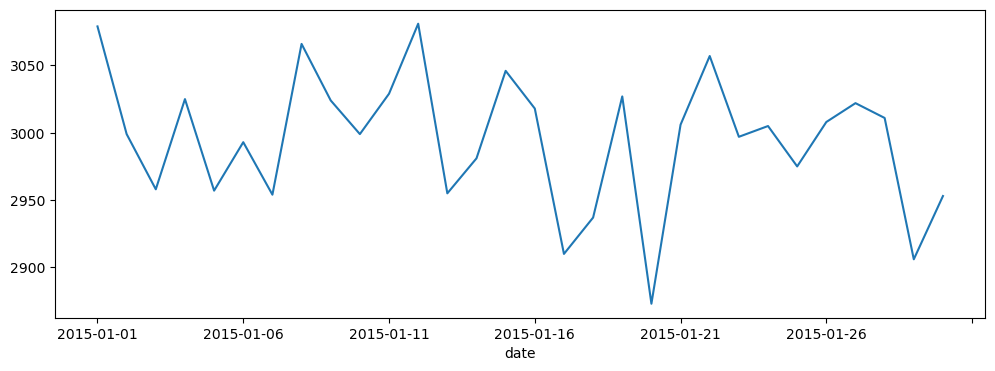

In [7]:
# Transactions plot
print(transactions['date'].min(), transactions['date'].max())
transactions.groupby(['date'])['account'].count().plot.line(figsize = [12,4])

<AxesSubplot: title={'center': 'Fraudulent transactions'}, xlabel='date'>

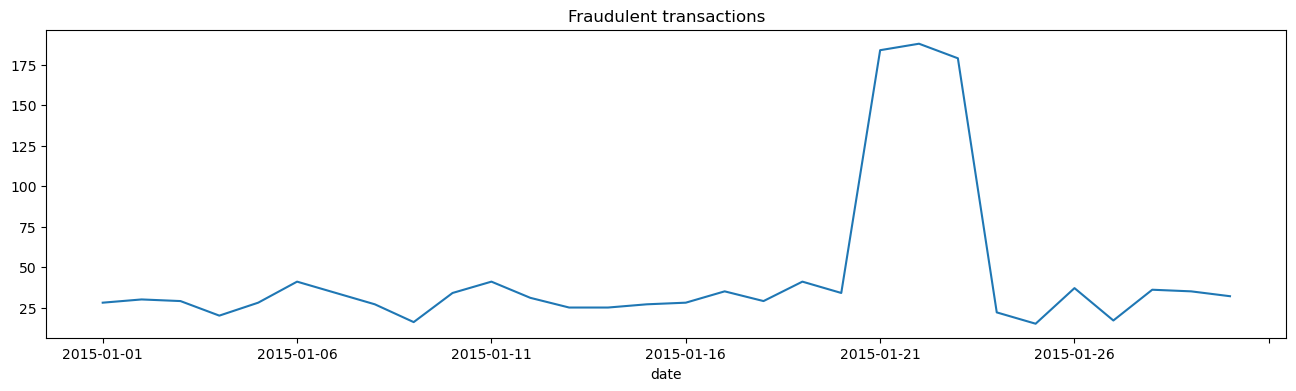

In [8]:
# Fraudulent transactions
transactions[transactions['fraud'] == True].groupby(['date'])['account'].count().plot.line(figsize = [16,4], title = "Fraudulent transactions")

In [9]:
# Fraudulent transactions (time-series)
transactions[transactions['fraud'] == True].groupby(['date'])['account'].count()

date
2015-01-01     28
2015-01-02     30
2015-01-03     29
2015-01-04     20
2015-01-05     28
2015-01-06     41
2015-01-07     34
2015-01-08     27
2015-01-09     16
2015-01-10     34
2015-01-11     41
2015-01-12     31
2015-01-13     25
2015-01-14     25
2015-01-15     27
2015-01-16     28
2015-01-17     35
2015-01-18     29
2015-01-19     41
2015-01-20     34
2015-01-21    184
2015-01-22    188
2015-01-23    179
2015-01-24     22
2015-01-25     15
2015-01-26     37
2015-01-27     17
2015-01-28     36
2015-01-29     35
2015-01-30     32
Name: account, dtype: int64

In [10]:
print("There are in total {} disticnt accounts".format(transactions['account'].drop_duplicates().shape[0]))
defrauded_accounts = transactions[transactions['fraud'] == True]['account'].drop_duplicates()
print("There are in total {} defrauded accounts".format(defrauded_accounts.shape[0]))

There are in total 1000 disticnt accounts
There are in total 617 defrauded accounts


In [11]:
# Data as type datetime
transactions['date_as_date'] = transactions['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d').date())
transactions['date_as_date'] = pd.to_datetime(transactions['date_as_date'], errors='coerce')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89851 entries, 0 to 89850
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   account       89851 non-null  object        
 1   date          89851 non-null  object        
 2   fraud         89851 non-null  bool          
 3   merchant      89851 non-null  object        
 4   date_as_date  89851 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(3)
memory usage: 2.8+ MB


# Final Approach

In a set of transactions, a common point of compromise can be identified when an unusually high number of defrauded accounts transacted with the same merchant some time before fraudulent transactions were seen for that account.

In [12]:
def estimate_10_day_intervals(input_date):
    if input_date < '2015-01-11':
        return "0-10"
    elif input_date < '2015-01-21':
        return "11-20"
    else:
        return "21-30"

In [13]:
# Defrauded accounts per merchant
defrauded_accounts_per_merchant = (transactions[(transactions['date'] < '2015-01-21') & (transactions['account'].isin(defrauded_accounts))].drop_duplicates(subset = ['account', 'merchant']).
groupby(['merchant'])['account'].count().reset_index().sort_values('account', ascending = False))
defrauded_accounts_per_merchant = defrauded_accounts_per_merchant.rename(columns = {'account' : 'Number of fraud accounts'})
# Total accounts per merchant
total_accounts_per_merchant = (transactions[(transactions['date'] < '2015-01-21')].drop_duplicates(subset = ['account', 'merchant']).
groupby(['merchant'])['account'].count().reset_index().sort_values('account', ascending = False))
total_accounts_per_merchant = total_accounts_per_merchant.rename(columns = {'account' : 'Number of accounts (traffic)'})
total_accounts_per_merchant
# Merge
defrauded_accounts_per_merchant = defrauded_accounts_per_merchant.merge(total_accounts_per_merchant, on ='merchant', how = 'left')
defrauded_accounts_per_merchant

,merchant,Number of fraud accounts,Number of accounts (traffic)
0,M48,309,486
1,M8,300,471
2,M61,297,483
3,M79,297,445
4,M62,297,471
...,...,...,...
95,M45,262,442
96,M14,262,430
97,M96,260,407
98,M60,256,441


In [14]:
# Approach
trans_per = transactions[transactions['account'].isin(defrauded_accounts)]  # all transactions of the defruaded accounts (transactions perimeter)
print(trans_per.shape)
trans_per_daily = trans_per.drop_duplicates(subset = ['account', 'merchant', 'date']) # remove if an account has transacted twice with the merchant
print(trans_per_daily.shape)
trans_per_daily["10_days_interval"] = trans_per_daily['date'].apply(lambda x : estimate_10_day_intervals(x))
pt_ten_days = pd.pivot_table(trans_per_daily, values = 'account', index = 'merchant', columns= '10_days_interval', aggfunc='count')
pt_ten_days['diff'] = pt_ten_days["11-20"] - pt_ten_days["0-10"]
pt_ten_days['percentage_diff (%)'] = ((pt_ten_days["11-20"] - pt_ten_days["0-10"])/ pt_ten_days["0-10"]) * 100
pt_ten_days['percentage_diff (%)'] = pt_ten_days['percentage_diff (%)'].apply(lambda x : round(x,2))
pt_ten_days = pt_ten_days.merge(defrauded_accounts_per_merchant, on ='merchant', how = 'left')
pt_ten_days.sort_values('diff',ascending = False)


(55872, 5)
(55066, 5)


/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_8093/3618845826.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_per_daily["10_days_interval"] = trans_per_daily['date'].apply(lambda x : estimate_10_day_intervals(x))


,merchant,0-10,11-20,21-30,diff,percentage_diff (%),Number of fraud accounts,Number of accounts (traffic)
51,M55,164,216,168,52,31.71,272,434
43,M48,185,221,190,36,19.46,309,486
49,M53,171,205,198,34,19.88,290,458
98,M98,167,201,162,34,20.36,274,431
26,M32,171,200,187,29,16.96,288,444
...,...,...,...,...,...,...,...,...
91,M91,217,187,175,-30,-13.82,294,468
50,M54,205,169,187,-36,-17.56,279,456
30,M36,199,159,181,-40,-20.10,278,456
0,M0,191,150,200,-41,-21.47,256,428


<AxesSubplot: title={'center': 'M55 - Transactions of fraudulent accounts'}, xlabel='date'>

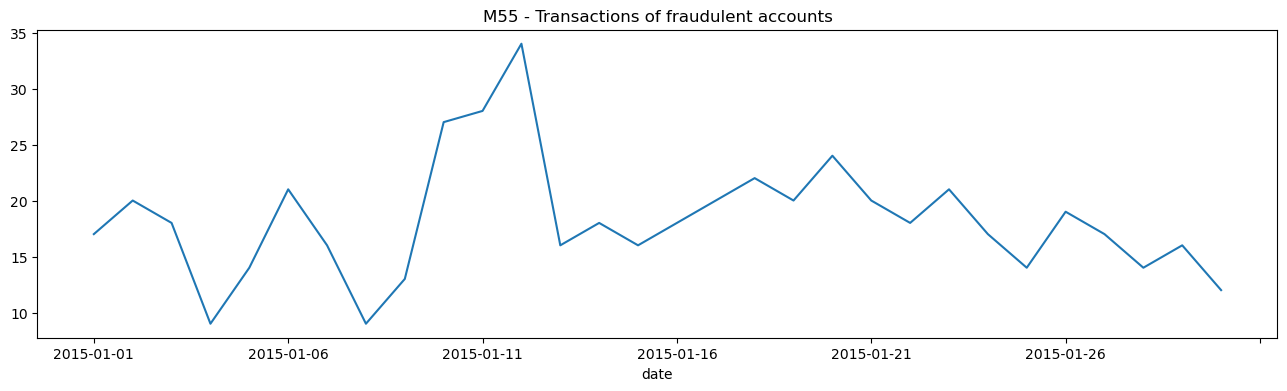

In [15]:
trans_per_daily[trans_per_daily['merchant'] == 'M55'].groupby(['date'])['account'].count().plot.line(figsize = [16,4], title = "M55 - Transactions of fraudulent accounts")

In [16]:
trans_per_daily[trans_per_daily['merchant'] == 'M55'].groupby(['date'])['account'].count()

date
2015-01-01    17
2015-01-02    20
2015-01-03    18
2015-01-04     9
2015-01-05    14
2015-01-06    21
2015-01-07    16
2015-01-08     9
2015-01-09    13
2015-01-10    27
2015-01-11    28
2015-01-12    34
2015-01-13    16
2015-01-14    18
2015-01-15    16
2015-01-16    18
2015-01-17    20
2015-01-18    22
2015-01-19    20
2015-01-20    24
2015-01-21    20
2015-01-22    18
2015-01-23    21
2015-01-24    17
2015-01-25    14
2015-01-26    19
2015-01-27    17
2015-01-28    14
2015-01-29    16
2015-01-30    12
Name: account, dtype: int64

In [167]:
# # Approach (Failed)
# transactions['week'] = transactions['date_as_date'].dt.week
# trans_per = transactions[transactions['account'].isin(defrauded_accounts)]  # all transactions of the defruaded accounts
# print(trans_per.shape)
# trans_per_before_fraud = trans_per[trans_per['week'].isin([1,2,3])]
# trans_per_before_fraud
# weekly_transactions = pd.pivot_table(trans_per_before_fraud, values = 'account', index= 'merchant', columns='week', aggfunc='count')#.rename(columns = {1: 'week_1', 2: "week_2", 3 : "week_3"})
# weekly_transactions["2_weeks_mean"] = weekly_transactions[[1,2]].mean(axis = 1)
# weekly_transactions["diff"] = weekly_transactions[3] - weekly_transactions['2_weeks_mean']
# weekly_transactions["diff_w3_w2"] = weekly_transactions[3] - weekly_transactions[2]
# weekly_transactions.sort_values("diff_w3_w2", ascending =False).head(30)

# # Transaction plots for possible compormise points
# trans_per[trans_per['merchant'] == 'M17'].groupby(['date'])['account'].count().plot.line(figsize = [16,4], title = "M17 Fraudulent transactions")
# trans_per[trans_per['merchant'] == 'M48'].groupby(['date'])['account'].count().plot.line(figsize = [16,4], title = "M48 Fraudulent transactions")
# trans_per[trans_per['merchant'] == 'M55'].groupby(['date'])['account'].count().plot.line(figsize = [16,4], title = "M55 Fraudulent transactions")